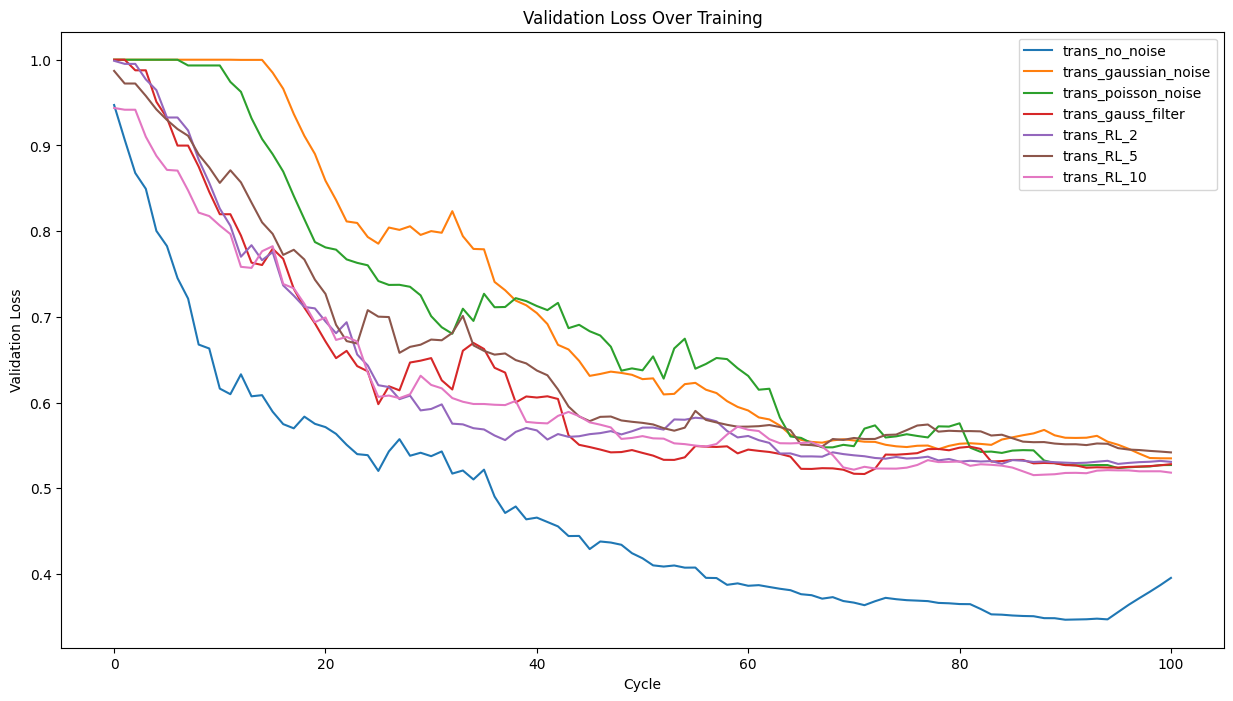

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from trainSettingsMult import *
from helpers.helpersGeneration import *
from helpers.helpersPlot import *
import pandas as pd
import seaborn as sns

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


def smooth_array(arr, n=5):
    pad = n // 2
    padded = np.pad(arr, pad, mode='edge')
    kernel = np.ones(n) / n
    smoothed = np.convolve(padded, kernel, mode='valid')
    return smoothed

# Load training results
results = torch.load("training_results_mult2.pth", map_location=torch.device('cpu'))


# Extract data
validation_losses = results["validation_losses"]
all_labels = results["all_labels"]
model_weights = results["model_weights"]

# Set up colors
tab20_colors = plt.get_cmap('tab20').colors
plt.figure(figsize=(15,8))

# Plot validation loss curves
for idx, (model_name, losses) in enumerate(validation_losses.items()):
    color = tab20_colors[idx % len(tab20_colors)]  # cycle through tab20 colors
    if("trans" in model_name):
        plt.plot(smooth_array(np.clip(losses["val_avg"], 0, 1),10), label=model_name, color=color)

plt.xlabel("Cycle")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Validation Loss Over Training")
plt.show()

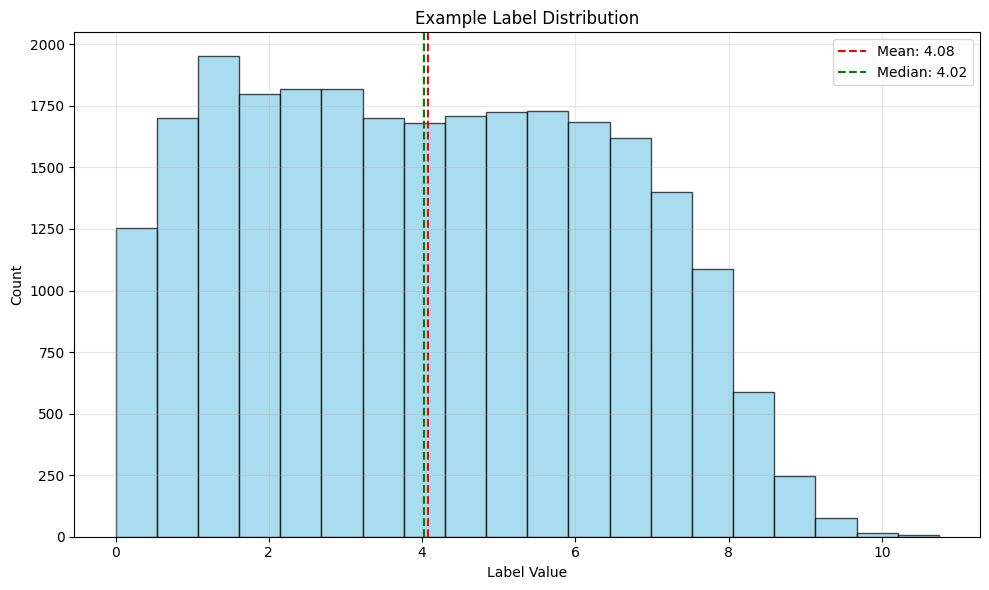

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_labels_histogram(labels_array, bins=10, title="Distribution of Labels", 
                          xlabel="Value", ylabel="Frequency", 
                          color='skyblue', edgecolor='black',
                          figsize=(10, 6), show_grid=True, 
                          show_mean=True, show_median=True):
    """
    Plot a histogram from a numpy array of labels.
    
    Parameters:
    -----------
    labels_array : numpy.ndarray
        The array of values to plot as histogram
    bins : int or sequence, default=10
        Number of bins or bin edges
    title : str, default="Distribution of Labels"
        Title of the plot
    xlabel : str, default="Value"
        Label for x-axis
    ylabel : str, default="Frequency"
        Label for y-axis
    color : str, default='skyblue'
        Color of the histogram bars
    edgecolor : str, default='black'
        Color of the histogram bar edges
    figsize : tuple, default=(10, 6)
        Figure size (width, height) in inches
    show_grid : bool, default=True
        Whether to show grid lines
    show_mean : bool, default=True
        Whether to show the mean line
    show_median : bool, default=True
        Whether to show the median line
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
        For further customization if needed
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram
    ax.hist(labels_array, bins=bins, color=color, edgecolor=edgecolor, alpha=0.7)
    
    # Add mean line if requested
    if show_mean and len(labels_array) > 0:
        mean_value = np.mean(labels_array)
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, 
                  label=f'Mean: {mean_value:.2f}')
    
    # Add median line if requested
    if show_median and len(labels_array) > 0:
        median_value = np.median(labels_array)
        ax.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Median: {median_value:.2f}')
    
    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Add grid
    if show_grid:
        ax.grid(alpha=0.3)
    
    # Add legend if we have mean or median
    if (show_mean or show_median) and len(labels_array) > 0:
        ax.legend()
    
    plt.tight_layout()
    
    return fig, ax

# Example usage
if __name__ == "__main__":
    # Example data
    
    # Plot histogram
    fig, ax = plot_labels_histogram(
        all_labels, 
        bins=20,
        title="Example Label Distribution",
        xlabel="Label Value",
        ylabel="Count"
    )
    
    plt.show()

In [16]:
from trainSettingsMult import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models, optimizers, schedulers = getModels()

def fix_mlp_head_keys(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith("mlp_head."):
            parts = key.split(".")
            layer_num = int(parts[1])
            # Map 0 -> 0, 2 -> 3, etc.
            if layer_num == 0:
                new_layer_num = 0
            elif layer_num == 2:
                new_layer_num = 3
            else:
                raise ValueError(f"Unexpected layer number in key: {key}")
            new_key = f"mlp_head.mlp.{new_layer_num}." + ".".join(parts[2:])
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict


for name in models:
    models[name] = models[name].to(device)
# Load model weights
for name, model in models.items():
    if name in model_weights:
        fixed_weights = fix_mlp_head_keys(model_weights[name])
        model.load_state_dict(fixed_weights)
        model.eval()  # Set to evaluation mode
        print(f"Loaded weights for {name}")
    else:
        print(f"Warning: No saved weights found for {name}")

Loaded weights for trans_no_noise
Loaded weights for resnet_no_noise
Loaded weights for trans_gaussian_noise
Loaded weights for resnet_gaussian_noise
Loaded weights for trans_poisson_noise
Loaded weights for resnet_poisson_noise
Loaded weights for trans_gauss_filter
Loaded weights for resnet_gauss_filter
Loaded weights for trans_RL_2
Loaded weights for resnet_RL_2
Loaded weights for trans_RL_5
Loaded weights for resnet_RL_5
Loaded weights for trans_RL_10
Loaded weights for resnet_RL_10


In [ ]:
def load_validation_dataMult(rl_iterations, length = 30):

    length_values = [20,30]
    if( length not in length_values):
        ValueError(f"Invalid length value, select one in: {length_values}")

    trajs1 = np.load("../validation_trajectories/"+str(length)+"/val1.npy") /traj_div_factor
    trajs3 = np.load("../validation_trajectories/"+str(length)+"/val3.npy") /traj_div_factor
    trajs5 = np.load("../validation_trajectories/"+str(length)+"/val5.npy") /traj_div_factor
    trajs7 = np.load("../validation_trajectories/"+str(length)+"/val7.npy") /traj_div_factor
    trajs_in_order = np.load("../validation_trajectories/valTrajsInOrder.npy") /traj_div_factor


    vid1 = trajs_to_vid_norm_rl(trajs1,nPosPerFrame,center=True,image_props=image_props, rl_iterations=rl_iterations)
    vid3 = trajs_to_vid_norm_rl(trajs3,nPosPerFrame,center=True,image_props=image_props, rl_iterations=rl_iterations)
    vid5 = trajs_to_vid_norm_rl(trajs5,nPosPerFrame,center=True,image_props=image_props, rl_iterations=rl_iterations)
    vid7 = trajs_to_vid_norm_rl(trajs7,nPosPerFrame,center=True,image_props=image_props, rl_iterations=rl_iterations)



    trajs_in_order = trajs_in_order.reshape(-1,T,2)
    vid_in_order = trajs_to_vid_norm_rl(trajs_in_order,nPosPerFrame,center=True,image_props=image_props, rl_iterations=RL_iterations)

    vid_in_order = vid_in_order.reshape(len(val_d_in_order),10,len(settings),nFrames,patch_size,patch_size)

    return torch.Tensor(vid1),torch.Tensor(vid3), torch.Tensor(vid5), torch.Tensor(vid7), torch.Tensor(vid_in_order)


val_videos = load_validation_dataMult(RL_iterations, nFrames)
print(val_videos[0].shape)

val_vid_in_order = val_videos[4]
print(val_vid_in_order.shape)

#val_vid_in_order = val_vid_in_order.reshape(len(val_d_in_order),10,7,nFrames,patch_size,patch_size)

print(val_vid_in_order.shape)
print(val_d_in_order.shape)
val_labels = torch.tensor([1, 3, 5, 7], dtype=torch.float32)  # Corresponding labels

In [18]:
def plot_model_predictions_violin(models, val_videos, val_labels, chosen_labels):
    """
    Plots a 2x2 grid of violin plots for the predictions of all models for specific validation labels.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7]) for example).
    - chosen_labels (list): List of validation labels to visualize (e.g., [7.0, 3.0, 1.0]).
    """
    
    # Check that all chosen labels are in the validation labels
    for chosen_label in chosen_labels:
        if chosen_label not in val_labels.tolist():
            print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
            return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 14))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten axes for easy iteration

    # Loop over the chosen labels and corresponding axes
    for idx, chosen_label in enumerate(chosen_labels):
        label_idx = val_labels.tolist().index(chosen_label)


        chosen_video = val_videos[label_idx]  # Get corresponding video

        predictions = {}

        # Compute predictions for each model
        for name, model in models.items():
            model.eval()
            with torch.no_grad():

                vid = chosen_video.to(device)

                idx_image = images_idx_from_name(name)

                vid = vid[:,idx_image]
                
                preds = model(vid).mean(dim=1).squeeze().tolist()  # Get all predictions for this video
                # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                preds_mult = np.array(preds) * D_max_normalization
                if(name == "trans_no_noise"):
                    preds_mult = preds_mult - 0.25
                predictions[name] = preds_mult 

        # Prepare data for Seaborn
        data = []
        for model_name, preds in predictions.items():
            for pred in preds:
                data.append({"Model": model_name, "Prediction": pred})

        # Convert to DataFrame for easy plotting
        df = pd.DataFrame(data)

        # Plot violin plot in the corresponding subplot
        sns.violinplot(x="Model", y="Prediction", data=df, inner="box", hue="Model", palette="coolwarm", ax=axes[idx])

        # Add reference line for true label
        axes[idx].axhline(y=chosen_label, color='r', linestyle='--', label=f"True Value: {chosen_label}")

        axes[idx].set_xlabel("Model")
        axes[idx].set_ylabel("Predicted Value")
        axes[idx].set_title(f"Model Predictions for Label {chosen_label}")
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend()

    plt.tight_layout()  # Adjust subplots to fit nicely
    plt.show()

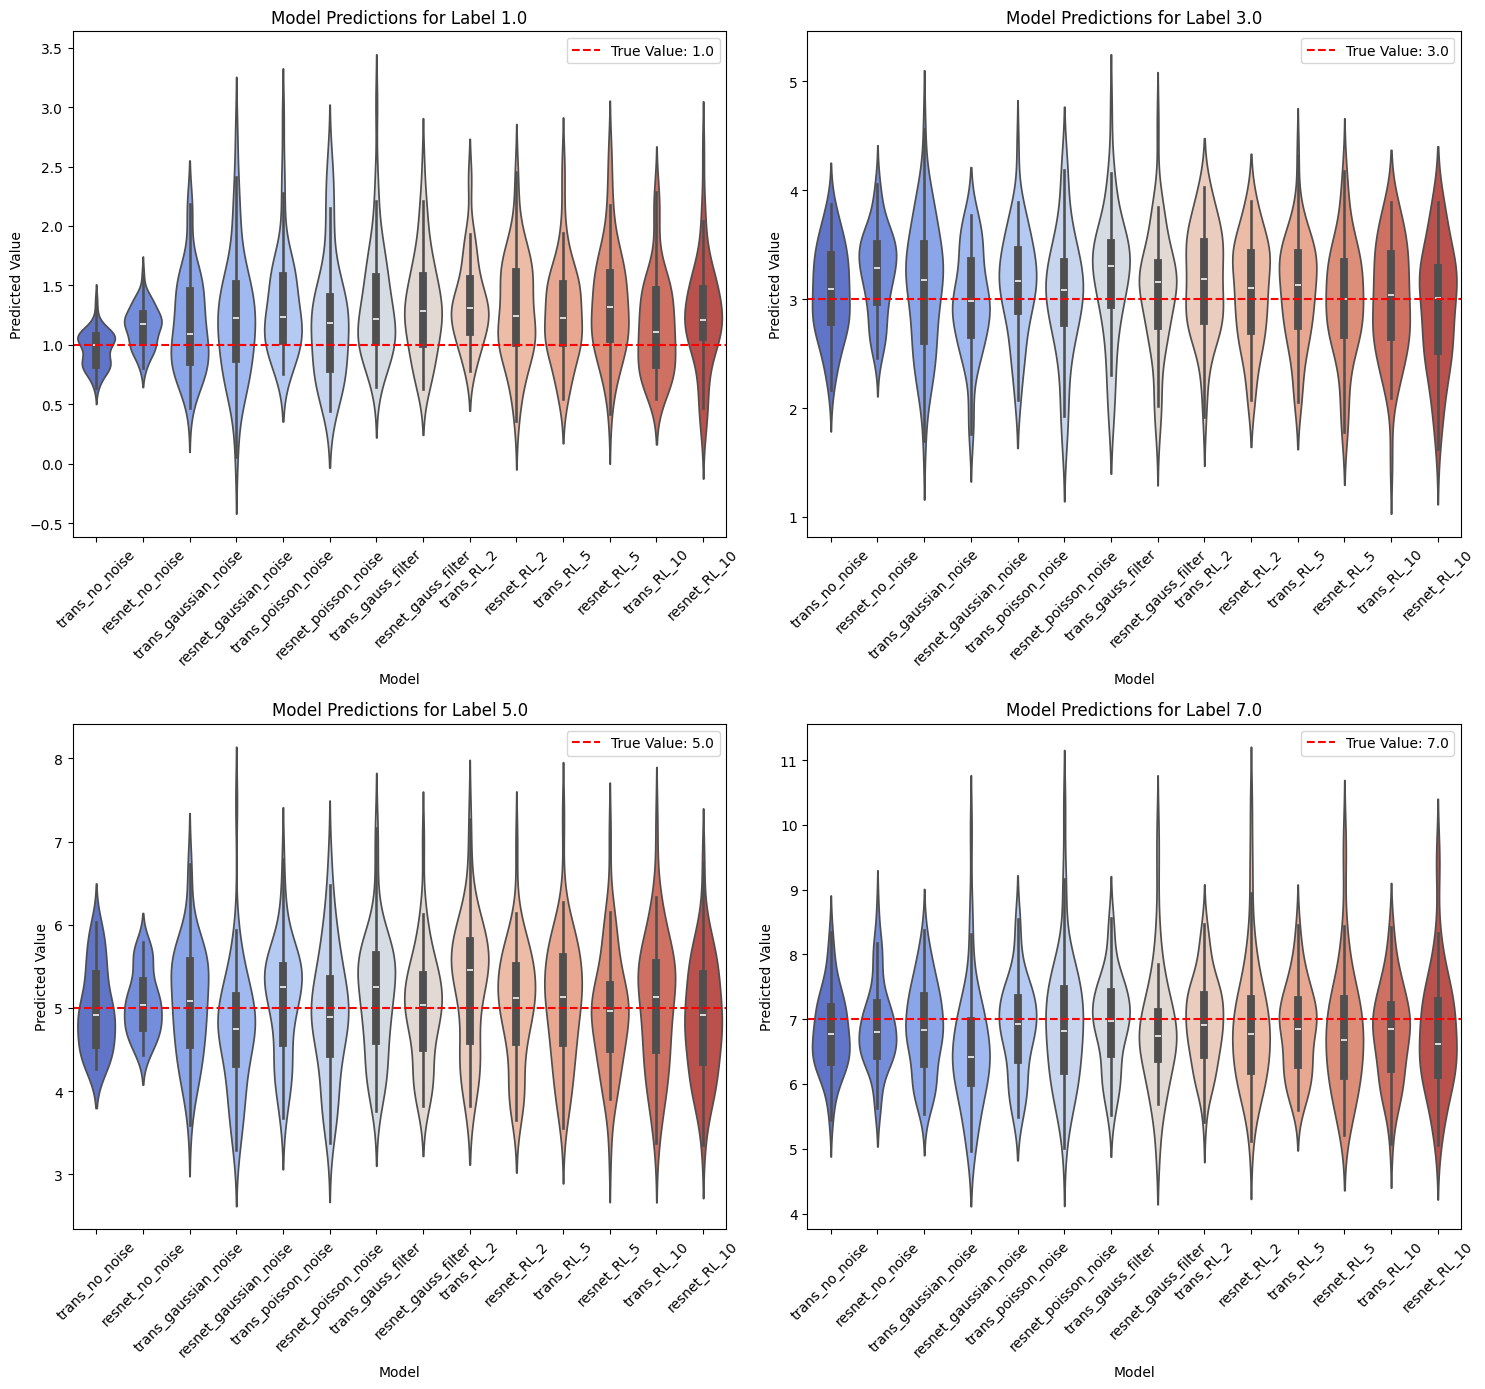

In [19]:
# Example usage
chosen_labels = [1.0, 3.0, 5.0, 7.0]
plot_model_predictions_violin(models, val_videos, val_labels, chosen_labels)

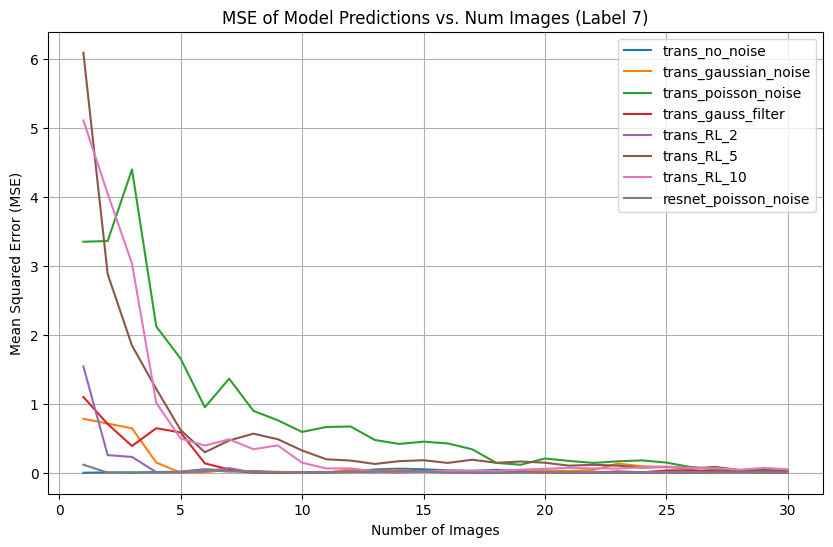

In [20]:
def plot_mse_vs_num_images(models, val_videos, val_labels, chosen_label, selected_models):
    """
    Plots the Mean Squared Error (MSE) of model predictions as a function of num_images.
    
    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7])).
    - chosen_label (int): The validation label to visualize (must be 1, 3, 5, or 7).
    """
    
    
    # Find index of the chosen label
    if chosen_label not in val_labels.tolist():
        print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
        return
    
    label_idx = val_labels.tolist().index(chosen_label)
    chosen_video = val_videos[label_idx]  # Get corresponding video
    
    num_images_range = range(1, chosen_video.shape[2] + 1)  # Range of num_images
    mse_results = {name: [] for name in selected_models}  # Store MSE results
    
    for num_images in num_images_range:
        input_video = chosen_video[:,:,:num_images]  # Select subset of images
        for name, model in models.items():
            if(name in selected_models):
                model.eval()
                with torch.no_grad():
                    
                    vid = input_video.to(device)
                    idx_images = images_idx_from_name(name)
                    vid = vid[:,idx_images]

                    pred = model(vid.contiguous()).mean().item()  # Aggregate predictions
                    # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                    pred = pred * D_max_normalization 
                    mse = (pred - chosen_label) ** 2  # Compute MSE
                    mse_results[name].append(mse)
    
    # Plot MSE as a function of num_images
    plt.figure(figsize=(10, 6))
    for name, mse_values in mse_results.items():
        plt.plot(num_images_range, mse_values, label=name)
    
    plt.xlabel("Number of Images")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(f"MSE of Model Predictions vs. Num Images (Label {chosen_label})")
    plt.legend()
    plt.grid(True)
    plt.show()

selected_models = [t_name(setting) for setting in settings]

selected_models.append("resnet_poisson_noise")

plot_mse_vs_num_images(models, val_videos, val_labels, 7,selected_models)

In [21]:
def plot_mse_vs_num_images_all_D(models, val_vid_in_order, val_d_in_order, selected_models):
    """
    Plots the average MSE of model predictions across all D values as a function of the number of images.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_vid_in_order (Tensor or ndarray): shape (70, 10, 30, 7, 7)
    - val_d_in_order (list or array): true D values, length 70.
    - selected_models (list): names of models to include in the plot.
    """

    if isinstance(val_vid_in_order, np.ndarray):
        val_vid_in_order = torch.tensor(val_vid_in_order, dtype=torch.float32)

    num_frames = val_vid_in_order.shape[3]
    num_images_range = range(1, num_frames + 1)  # From 1 to 30
    mse_results = {name: [] for name in selected_models}

    for num_images in num_images_range:
        for name in selected_models:
            model = models[name]
            model.eval()
            total_mse = 0.0
            with torch.no_grad():
                for i, true_d in enumerate(val_d_in_order):
                    videos = val_vid_in_order[:,i, :, :num_images]  # shape (10, num_images, 7, 7)
                    
                    vid = videos.to(device)
                    idx = images_idx_from_name(name)
                    vid = vid[idx]
                    
                    preds = model(vid)  # assume shape (10, N)
                    mean_preds = preds.mean(dim=1)  # mean over frames
                    # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                    mean_preds = mean_preds * D_max_normalization
                    mean_over_10 = mean_preds.mean().item()  # mean over 10 samples
                    total_mse += (mean_over_10 - true_d) ** 2
            avg_mse = total_mse / len(val_d_in_order)
            mse_results[name].append(avg_mse)

    # Plotting
    plt.figure(figsize=(10, 6))
    for name, mse_values in mse_results.items():
        plt.plot(num_images_range, mse_values, label=name)

    plt.xlabel("Number of Images")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Average MSE vs. Number of Images (Averaged over all D)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_mse_vs_num_images_all_D(models, val_vid_in_order, val_d_in_order, selected_models)


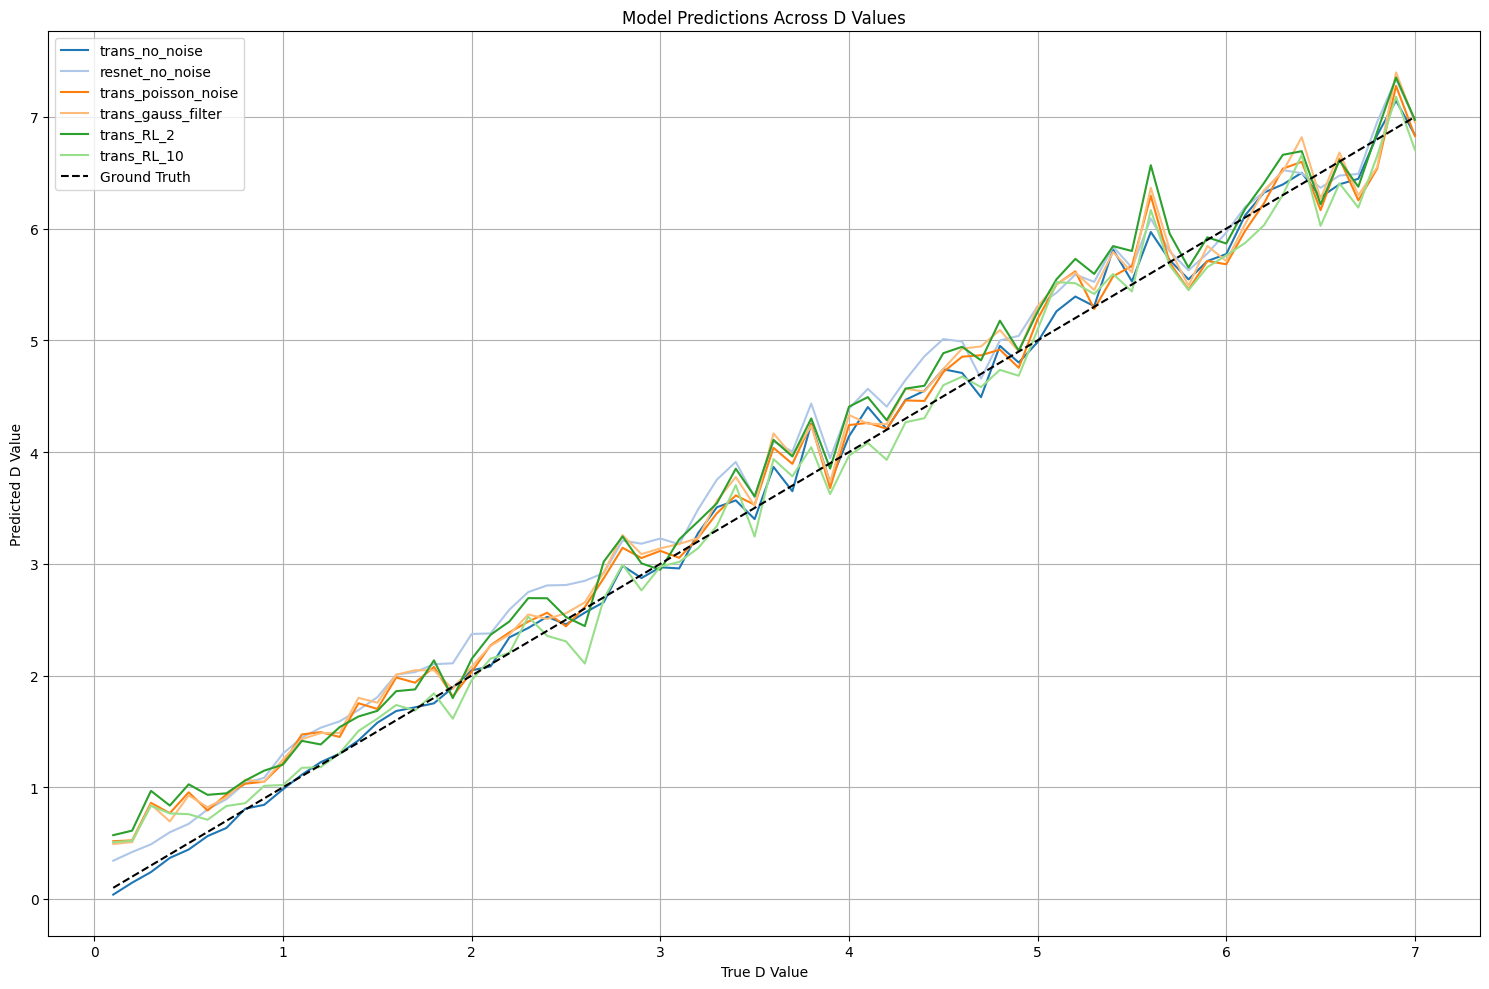

In [22]:

def plot_model_predictions_vs_D_in_order(models, val_vid_in_order, val_d_in_order, selected_models):
    """
    Plots line graphs of model predictions across increasing D values.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_vid_in_order (numpy array or torch.Tensor): Array of shape (70, 10, 30, 7, 7).
    - val_d_in_order (list or array): Corresponding true D values (length 70).
    """
    tab20_colors = plt.get_cmap('tab20').colors


    # Convert to torch tensor if needed
    if isinstance(val_vid_in_order, np.ndarray):
        val_vid_in_order = torch.tensor(val_vid_in_order, dtype=torch.float32)

    model_preds = {name: [] for name in selected_models}

    for i in range(len(val_d_in_order)):
        vids = val_vid_in_order[i]  # shape (5, 10, 30, 7, 7)
        for name in selected_models:
            model = models[name]
            model.eval()
            with torch.no_grad():

                vid = vids.to(device)
                idx_images = images_idx_from_name(name)
                vid = vid[:,idx_images]

                preds = model(vid)

                # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                preds = preds * D_max_normalization
                if(name == "trans_no_noise"):
                    preds = preds - 0.25
                if(name == "resnet_no_noise"):
                    preds = preds + 0.1
                mean_of_means = preds.mean().item()  # mean over sequences
                model_preds[name].append(mean_of_means)

    # Plot
    plt.figure(figsize=(15, 10))
    for i,(name, preds) in enumerate(model_preds.items()):
        color = tab20_colors[i % len(tab20_colors)]  # cycle through tab20 colors

        plt.plot(val_d_in_order, preds, label=name, color=color)

    plt.plot(val_d_in_order, val_d_in_order, 'k--', label='Ground Truth')  # y = x reference
    plt.xlabel("True D Value")
    plt.ylabel("Predicted D Value")
    plt.title("Model Predictions Across D Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


selected_models = ["trans_no_noise", "resnet_no_noise", "trans_poisson_noise", "trans_gauss_filter" ,"trans_RL_2", "trans_RL_10"]
plot_model_predictions_vs_D_in_order(models, val_vid_in_order, val_d_in_order,selected_models)# list(models.keys())[:10])

In [49]:
vids = val_vid_in_order[:,0]

print(vids.shape)
sel_models.append("trans_RL_10")
for name in sel_models:
    model = models[name]
    model.eval()
    with torch.no_grad():

        vid = vids.to(device)
        idx_images = images_idx_from_name(name)
        vid = vid[:,idx_images]
        preds = model(vid)
        idx = 68
        print(name, preds[idx]*D_max_normalization)
        play_video(vid[idx])


torch.Size([70, 7, 30, 9, 9])
trans_no_noise tensor([6.8295])
vmin: -0.26461344957351685 vmax: 0.7025564312934875 mean: -0.16


trans_poisson_noise tensor([6.9950])
vmin: -0.13256439566612244 vmax: 1.0591826438903809 mean: 0.17


trans_gauss_filter tensor([7.0868])
vmin: -0.08523730933666229 vmax: 0.9628791809082031 mean: 0.17


trans_RL_2 tensor([7.3048])
vmin: 0.0027753766626119614 vmax: 1.0 mean: 0.18


trans_RL_10 tensor([6.7224])
vmin: 0.00610911613330245 vmax: 1.0 mean: 0.17


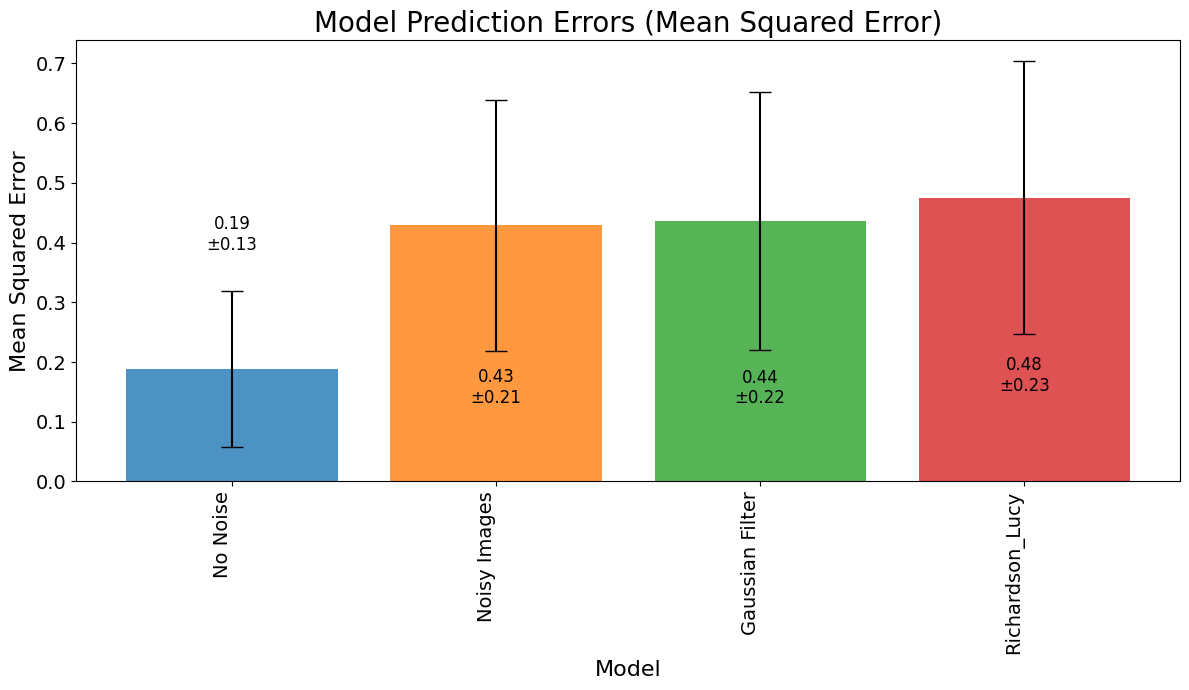

In [ ]:
def plot_error_std(selected_models, mse_dict, std_dict, models_colormap):
    """
    Plot bar graph of Mean Squared Error with error bars representing standard deviation.
    """
    plt.figure(figsize=(12, 7))

    colors = [models_colormap[name] for name in selected_models]

    # Prepare data
    model_names = list(selected_models)
    model_names_mapped = [name_map[name] for name in model_names]
    mean_errors = [mse_dict[name_map[name]] for name in model_names]
    std_errors = [std_dict[name_map[name]] for name in model_names]

    # Bar plot
    bars = plt.bar(
        model_names_mapped, mean_errors, yerr=std_errors,
        capsize=8, alpha=0.8, color=colors, linewidth=1.5
    )

    plt.title('Model Prediction Errors (Mean Squared Error)', fontsize=20)
    plt.xlabel('Model', fontsize=16)
    plt.ylabel('Mean Squared Error', fontsize=16)
    plt.xticks(rotation=90, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    # Add error values above bars
    for i, (mean, std) in enumerate(zip(mean_errors, std_errors)):
        if(i==0):
            y = mean + 1.4* std + 0.02 * max(mean_errors)  # small offset
        else:
            y = mean - 1.4* std - 0.02 * max(mean_errors)  # small offset
        plt.text(i, y, f'{mean:.2f}\n±{std:.2f}', ha='center', va='bottom', fontsize=12)

    plt.show()




def compute_erro_all_d(models, val_vid_in_order,val_d_in_order, selected_models):
    """
    Plots line graphs of model predictions and bar graph of errors across increasing D values.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_vid_in_order (numpy array or torch.Tensor): Array of shape (70, 10, 30, 7, 7).
    - val_d_in_order (list or array): Corresponding true D values (length 70).
    """


    if isinstance(val_d_in_order, np.ndarray):
        val_d_in_order = torch.tensor(val_d_in_order, dtype=torch.float32)


    # Reshape video tensor to (700, 30, 9, 9)
    val_vid_reshaped = val_vid_in_order.view(-1,7, 30, 9, 9).to(device)
    
    # Explicitly repeat val_d_in_order 10 times to create a (700,) array
    true_d_repeated = torch.repeat_interleave(val_d_in_order, repeats=10).unsqueeze(1)

    # Dictionaries to store predictions, MSE, and standard deviation
    model_preds = {name: [] for name in selected_models}
    mse_dict = {}
    std_dict = {}

    for name in selected_models:
        model = models[name]

        with torch.no_grad():
            vid = val_vid_reshaped.to(device)
            idx_images = images_idx_from_name(name)
            vid = vid[:,idx_images]
            preds = model(vid)

            # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
            preds = preds * D_max_normalization

            if(name == "trans_no_noise"):
                preds = preds - 0.27
            if(name == "resnet_no_noise"):
                preds = preds + 0.1
            # Extract numpy arrays from tensors
            preds_np = preds.cpu().numpy()
            true_np = true_d_repeated.cpu().numpy()
            errors = preds_np - true_np
            # Add epsilon to denominator to avoid division by zero
            epsilon = 1e-8
            scaled_errors = errors / (true_np + epsilon)
            scaled_errors = errors
            # Step 3: Compute the scaled Mean Squared Error (MSE)
            scaled_mse = np.mean(scaled_errors**2)
            #scaled_mse = np.mean(np.abs(scaled_errors))

            # Step 4: Compute the standard deviation of the scaled squared errors
            scaled_std = np.std(scaled_errors**2)/3
            #scaled_std = np.std(np.abs(scaled_errors))

            # Store MSE and standard deviation
            mse_dict[name_map[name]] = scaled_mse
            std_dict[name_map[name]] = scaled_std
    return mse_dict, std_dict

name_map = {"trans_no_noise" : "No Noise",
             "trans_poisson_noise": "Noisy Images", "trans_gauss_filter": "Gaussian Filter", "trans_RL_2": "Richardson_Lucy"}

cmap = plt.get_cmap("RdYlGn")
tab10_colors = plt.get_cmap('tab10').colors
sel_models= ["trans_no_noise", "trans_poisson_noise", "trans_gauss_filter", "trans_RL_2"]

colors_dict = {n:tab10_colors[i%len(tab10_colors)] for i,n in enumerate(sel_models)}
mse_dict,std_dict = compute_erro_all_d(models, val_vid_in_order, val_d_in_order, sel_models)
plot_error_std(sel_models, mse_dict, std_dict, colors_dict)

